In [1]:
import numpy as np
import pandas as pd
import json
from scipy.signal import find_peaks
from tqdm import tqdm
import anndata as ad

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

import src.utilities as utils
from src.slide_utilities import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
adata_all = sc.read_h5ad("data/adata_nichepca_clustered_per_sample_tmp.h5ad")
df_res = pd.read_csv("data/best_resolution.csv", index_col=0)
sample_set = adata_all.obs['sample'].unique()
sample_set

['X40', 'X39', 'X38', 'X37', 'X36', ..., 'X21', 'X20', 'X19', 'X18', 'X17']
Length: 63
Categories (63, object): ['X1', 'X2', 'X3', 'X4', ..., 'X60', 'X61', 'X62', 'X63']

In [3]:
sample = 'X1'
adata = adata_all[adata_all.obs['sample'] == sample]

In [4]:
cols = list(adata.obs.columns)
cols_with_leiden = [c for c in cols if c.find('leiden') > 0]
cols_with_leiden

['per_sample_leiden_res_0.03',
 'per_sample_leiden_res_0.05',
 'per_sample_leiden_res_0.07',
 'per_sample_leiden_res_0.09',
 'per_sample_leiden_res_0.11',
 'per_sample_leiden_res_0.13',
 'per_sample_leiden_res_0.15',
 'per_sample_leiden_res_0.17',
 'per_sample_leiden_res_0.19',
 'per_sample_leiden_res_0.21',
 'per_sample_leiden_res_0.23',
 'per_sample_leiden_res_0.25',
 'per_sample_leiden_res_0.27',
 'per_sample_leiden_res_0.29',
 'per_sample_leiden_res_0.31',
 'per_sample_leiden_res_0.33',
 'per_sample_leiden_res_0.35',
 'per_sample_leiden_res_0.37',
 'per_sample_leiden_res_0.39']

In [5]:
# add cluster markers
# resolution_best = cols_with_leiden[5]
resolution_best = df_res.loc[sample, 'resolution']
resolution_best = f"per_sample_leiden_res_{resolution_best}"

adata = add_markers(adata, 
                    markers = KidneyCellMarkers, 
                    groupby = resolution_best,
                    colormap = colormap,
                    marker_subset = marker_subset, 
                    keyadded = 'final_clusters',
                    verbos=True,
                    return_adata = True
                   )

Cluster number to marker dict:
{'5': {'set': 'Glom.', 'max': 0.3521425, 'diff': 0.348987486537922}, '0': {'set': 'Prox. Tubule', 'max': 0.41892642, 'diff': 0.388190596185001}, '3': {'set': 'DistaL Con. Tubule', 'max': 0.72549087, 'diff': 0.5001781093801787}}


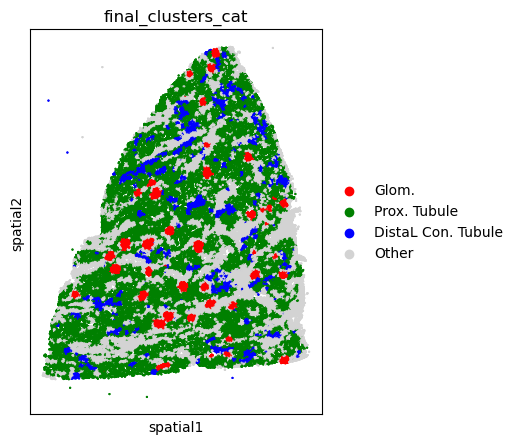

In [6]:
# spatial plot
fig, ax = plt.subplots(figsize=(5, 5))
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color='final_clusters_cat',
    wspace=0.1,
    ax = ax
)

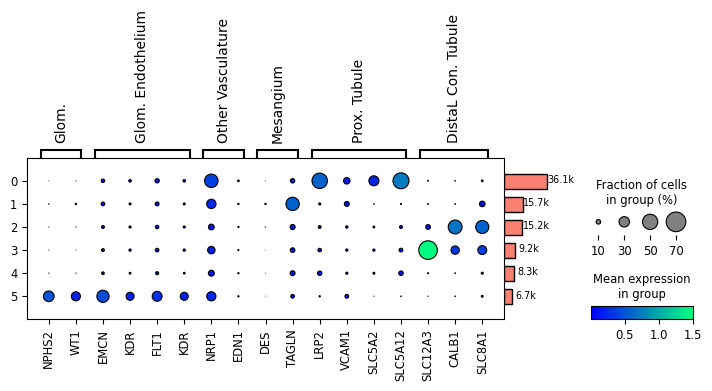

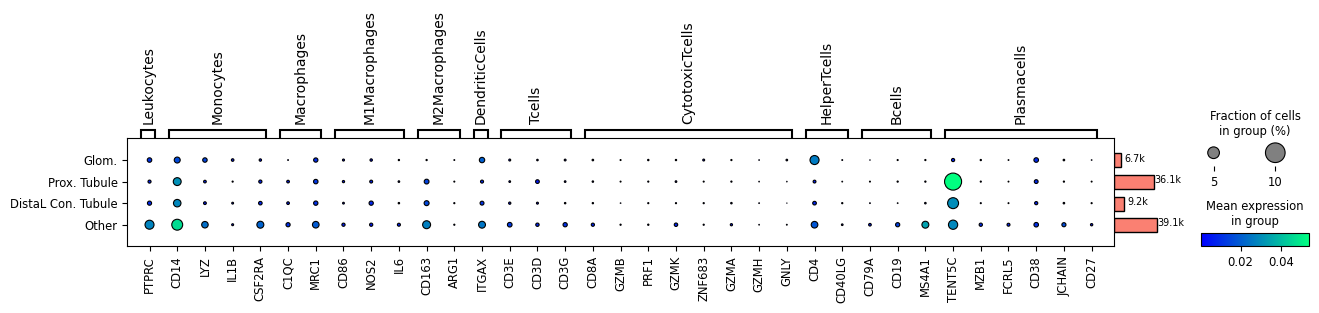

In [7]:
Markers = remove_extra_genes(KidneyCellMarkers, adata)
dp = sc.pl.dotplot(adata, Markers, groupby=resolution_best, use_raw=False, return_fig=True)
dp.style(dot_edge_color='black', dot_edge_lw=.8)
dp.add_totals()
# dp.savefig("marker.pdf")
dp.show()

# Immunological enrichment
Markers = remove_extra_genes(ImmuneMarkers, adata)
dp = sc.pl.dotplot(adata, Markers, groupby='final_clusters_cat', use_raw=False, return_fig=True)
dp.style(dot_edge_color='black', dot_edge_lw=.8)
dp.add_totals()
dp.show()

## Do all in a loop

In [9]:
# adata_all = sc.read_h5ad("data/adata_nichepca_slide_clustered_tmp.h5ad")
# sample_set = adata_all.obs['Patient_Sample_ID'].unique()
# resolution_best = 'per_slide_leiden_0.2_1'

In [2]:
adata_all = sc.read_h5ad("data/adata_nichepca_clustered_per_sample_tmp.h5ad")
adata_all = ad.AnnData(
    X=adata_all.X, 
    obs=adata_all.obs,
    var=adata_all.var,
    uns={'spatial': adata_all.uns['spatial']},
    obsm={'spatial': adata_all.obsm['spatial']}
)
adata_all

AnnData object with n_obs × n_vars = 3222037 × 480
    obs: 'x', 'y', 'z', 'cluster', 'n_transcripts', 'density', 'elongation', 'area', 'avg_confidence', 'avg_assignment_confidence', 'max_cluster_frac', 'lifespan', 'x_centroid', 'y_centroid', 'cell_area', 'Slide_ID', 'batch', 'Patient_Sample_ID', 'Disease', 'n_genes', 'celltype_l1', 'celltype_l1_codes', 'celltype_l1_prob', 'Biopsy_ID', 'sample', 'per_sample_leiden_res_0.03', 'per_sample_leiden_res_0.05', 'per_sample_leiden_res_0.07', 'per_sample_leiden_res_0.09', 'per_sample_leiden_res_0.11', 'per_sample_leiden_res_0.13', 'per_sample_leiden_res_0.15', 'per_sample_leiden_res_0.17', 'per_sample_leiden_res_0.19', 'per_sample_leiden_res_0.21', 'per_sample_leiden_res_0.23', 'per_sample_leiden_res_0.25', 'per_sample_leiden_res_0.27', 'per_sample_leiden_res_0.29', 'per_sample_leiden_res_0.31', 'per_sample_leiden_res_0.33', 'per_sample_leiden_res_0.35', 'per_sample_leiden_res_0.37', 'per_sample_leiden_res_0.39'
    var: 'gene_ids', 'feature_ty

In [3]:
df_res = pd.read_csv("data/best_resolution.csv", index_col=0)
sample_set = adata_all.obs['sample'].unique()
sample_set

['X40', 'X39', 'X38', 'X37', 'X36', ..., 'X21', 'X20', 'X19', 'X18', 'X17']
Length: 63
Categories (63, object): ['X1', 'X2', 'X3', 'X4', ..., 'X60', 'X61', 'X62', 'X63']

In [4]:
adata_all.obs['domains'] = 'na'

for sample in tqdm(sample_set):

    adata = adata_all[adata_all.obs['sample'] == sample]
    
    # add cluster markers
    resolution_best = df_res.loc[sample, 'resolution']
    if resolution_best == 'none':
        continue
    resolution_best = f"per_sample_leiden_res_{resolution_best}"

    adata = add_markers(adata, 
                        markers = KidneyCellMarkers, 
                        groupby = resolution_best,
                        colormap = colormap,
                        marker_subset = marker_subset, 
                        keyadded = 'final_clusters',
                        verbos=False,
                        return_adata = True
                       )
    
    adata_all.obs.loc[adata_all.obs['sample'] == sample ,'domains'] = adata.obs['final_clusters_cat']

100%|██████████| 63/63 [1:02:19<00:00, 59.36s/it] 


In [5]:
adata_all.obs

,x,y,z,cluster,n_transcripts,density,elongation,area,avg_confidence,avg_assignment_confidence,...,per_sample_leiden_res_0.23,per_sample_leiden_res_0.25,per_sample_leiden_res_0.27,per_sample_leiden_res_0.29,per_sample_leiden_res_0.31,per_sample_leiden_res_0.33,per_sample_leiden_res_0.35,per_sample_leiden_res_0.37,per_sample_leiden_res_0.39,domains
cell_CRfb095a77d-1,2285.790178,1164.057381,32.829188,1,79,2.0240,2.141,39.03,0.9975,0.9916,...,1,2,2,2,2,2,2,2,2,Prox. Tubule
cell_CRfb095a77d-2,2298.342622,1219.741069,31.465535,4,32,1.0850,4.614,29.50,0.9771,0.9288,...,1,2,2,2,2,2,2,2,2,Prox. Tubule
cell_CRfb095a77d-3,2271.434052,1245.859500,32.062796,2,67,3.0590,2.990,21.90,0.9971,0.9884,...,3,4,4,4,4,4,5,4,7,DistaL Con. Tubule
cell_CRfb095a77d-5,2257.346907,1259.955827,31.273945,2,56,2.1420,9.229,26.14,0.9964,0.9707,...,3,4,4,4,4,4,5,4,7,DistaL Con. Tubule
cell_CRfb095a77d-6,2277.712022,1237.595244,35.395148,2,9,1.6980,3.283,5.30,0.9826,0.9400,...,3,4,4,4,4,4,5,4,7,DistaL Con. Tubule
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_CRc71d71060-597925,2747.360264,4957.516627,24.097605,2,73,1.5480,3.617,47.15,0.9971,0.6334,...,1,1,1,1,1,1,1,1,1,Other
cell_CRc71d71060-598041,4592.548620,1655.438877,24.254944,2,35,0.9893,1.844,35.38,0.9951,0.6206,...,1,1,1,1,1,1,1,1,1,Other
cell_CRc71d71060-598270,8540.113826,9224.561804,19.515240,3,46,1.3870,2.667,33.16,0.9969,0.7152,...,1,1,1,1,1,1,1,1,1,Other
cell_CRc71d71060-598508,4264.902000,2582.697217,25.121288,3,24,1.1420,5.004,21.02,0.9914,0.7517,...,1,6,6,6,6,6,6,7,7,Other


In [ ]:
adata_all.write("data/adata_nichepca_per_sample_with_domain.h5ad")